# Practical session n°2

In Part I:
- Training a CNN on MNIST. Comparison with a multi-layer perceptron.
- Initialization methods, regularization methods.

In Part II:

- Learning on a graphics card.
- Improving gradient descent: SGD with momentum and progressive learning rate decay (scheduler).
- Transfer learning: fine-tuning and freezing.

Duration: 2 h

**Part I**


Now that we have covered the basic building blocks, we will train a Convolutional Neural Network (CNN) on a slightly more challenging problem than separation of points in a 2D space: handwritten digit recognition.

The dataset is named MNIST. It is located in the shared folder and comprises black and white (1 channel) images of 28x28 pixels. A specific dataset object is allocated to it in the torchvision.datasets module. The subsequent cells are designed to import packages, download the dataset, and showcase some images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [2]:
root = '.'

# transforms (format/normalization)
tr=torchvision.transforms.Compose([
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
   ])

# Definition of training sets:
ds = {'train': torchvision.datasets.MNIST(root='./data',
                                          train = True,
                                          download = True,
                                          transform = tr
                                          ),
      'val': torchvision.datasets.MNIST(root='./data',
                                        train = False,
                                        download = True,
                                        transform = tr)
     }

100%|██████████| 9912422/9912422 [00:00<00:00, 114883671.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 120055197.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 52593129.91it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1124057.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
phases = ['train','val']

# Dataloaders:
bs = 8
loader ={x :  DataLoader(ds[x], batch_size=bs, shuffle=True, num_workers = 4) for x in phases}
# To parallelize the loading of thumbnails into RAM:
num_workers = 2
# (data loading is thus parallelized, for even faster performance, we will use a GPU - see Part II)

# Sizes (for score calculation)
dataset_sizes = {x: len(ds[x]) for x in  phases}

# we fix the random number generator
random_seed = 1
torch.manual_seed(random_seed)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([8, 1, 28, 28])


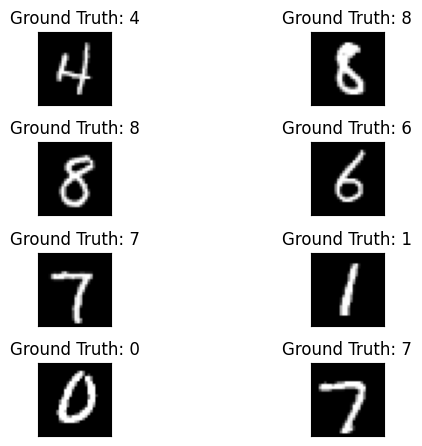

In [4]:
x, t = next(iter(loader['train']))

print(x.shape)

fig = plt.figure()
for i in range(8):
  plt.subplot(4,2,i+1)
  plt.tight_layout()
  plt.imshow(x[i,0,:,:], cmap='gray') #, interpolation='none')
  plt.title("Ground Truth: {}".format(t[i]))
  plt.xticks([])
  plt.yticks([])



Now, we will define a shallow CNN (two convolution layers).

**Exercise:**  Determine *N* in such a way that the network can accept MNIST images as input.

In [19]:
# N = ...
### BEGIN SOLUTION
N = 490
### END SOLUTION

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(N, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, N)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # Here, the log is applied after the softmax:
        return F.log_softmax(x, dim=1)

In [20]:
model = CNN()

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# We select the log likelihoods for the true classes:
loss_fn =  torch.nn.NLLLoss()

The training loop has two phases: weights are updated only in the first phase dedicated to training. During the validation phase, generalization performance on independent images is monitored:

In [ ]:
import time

# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(6):
    print(f'Epoch: {epoch}')

    running_loss_train = 0.0
    running_corrects_train = 0
    running_loss_val = 0.0
    running_corrects_val = 0

    # Phase 1: Training
    model.train()  # Set the model to training mode
    for x, label in loader['train']:
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Update counters:
        running_loss_train += loss.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores:
    epoch_loss_train = running_loss_train / dataset_sizes['train']
    epoch_acc_train = running_corrects_train.float() / dataset_sizes['train']

    print(f'Train Loss: {epoch_loss_train:.4f} Acc: {epoch_acc_train:.4f}')

    # Phase 2: Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for x, label in loader['val']:
            output = model(x)
            loss = loss_fn(output, label)

            # Get predicted classes:
            _, preds = torch.max(output, 1)

            # Update counters:
            running_loss_val += loss.item() * x.shape[0]
            running_corrects_val += torch.sum(preds == label.data)

    # Calculate validation scores and print:
    epoch_loss_val = running_loss_val / dataset_sizes['val']
    epoch_acc_val = running_corrects_val.float() / dataset_sizes['val']

    print(f'Validation Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}')

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')

    # Update start time for the next epoch
    start_time = time.time()

**Exercise**:
At each epoch, store the accuracy and the cost function value in the lists train_losses, val_losses, train_accs, and val_accs.
Plot the **learning curves** over six epochs. \\

In [21]:
train_losses = []
val_losses = []

train_accs = []
val_accs = []

### BEGIN SOLUTION

# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(6):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    # Training
    for x, label in loader['train']:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores and store:


    epoch_loss_train = running_loss_train / dataset_sizes['train']
    epoch_acc_train = running_corrects_train.float() / dataset_sizes['train']


    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))


    # validation
    model.eval()

    for x, label in loader['val']:

        with torch.no_grad():
            output = model(x)
            l = loss_fn(output, label)

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_val = running_loss_val / dataset_sizes['val']
    epoch_acc_val = running_corrects_val.float() / dataset_sizes['val']


    val_losses.append(epoch_loss_val)
    val_accs.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')


### END SOLUTION

epoch :0
train Loss: 0.3114 Acc: 0.9031
val Loss: 0.0658 Acc: 0.9788
Time: 66 seconds
epoch :1
train Loss: 0.0600 Acc: 0.9814
val Loss: 0.0455 Acc: 0.9863
Time: 129 seconds
epoch :2
train Loss: 0.0453 Acc: 0.9857
val Loss: 0.0413 Acc: 0.9872
Time: 190 seconds
epoch :3
train Loss: 0.0374 Acc: 0.9883
val Loss: 0.0389 Acc: 0.9886
Time: 252 seconds
epoch :4
train Loss: 0.0315 Acc: 0.9900
val Loss: 0.0429 Acc: 0.9874
Time: 312 seconds
epoch :5
train Loss: 0.0274 Acc: 0.9914
val Loss: 0.0413 Acc: 0.9893
Time: 374 seconds


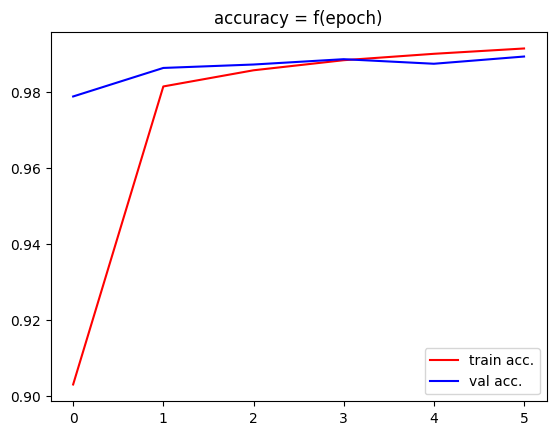

In [22]:
fig, ax = plt.subplots()
plt.title('accuracy = f(epoch)')
### BEGIN SOLUTION
ax.plot(np.arange(6), np.array(train_accs), color = 'r')
ax.plot(np.arange(6), np.array(val_accs), color = 'b')
ax.legend(['train acc.', 'val acc.'])
### END SOLUTION

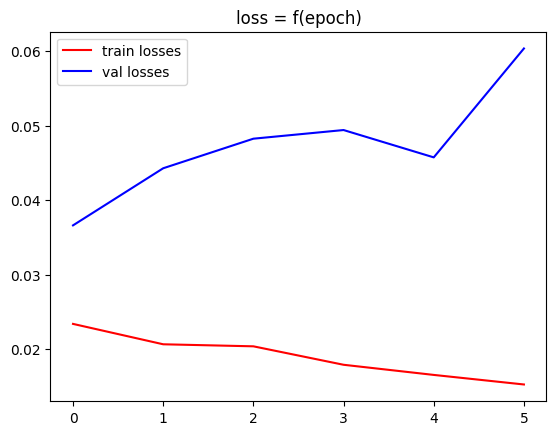

In [ ]:
fig2, ax2 = plt.subplots()
### BEGIN SOLUTION
plt.title('loss = f(epoch)')
ax2.plot(np.arange(6), np.array(train_losses), color = 'r')
ax2.plot(np.arange(6), np.array(val_losses), color = 'b')
ax2.legend(['train losses', 'val losses'])
### END SOLUTION

**Exercise:** Take the two-layer perceptron (fc1 and fc2) from the TP1 part 1 and modify it to directly take MNIST images as input.
Compare the standalone perceptron to the CNN in terms of size (number of weights) and performance.

In [ ]:
### BEGIN SOLUTION
class P60(nn.Module):

    def __init__(self):
        super(P60, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

perceptron = P60()
optimizer = torch.optim.Adam(perceptron.parameters(), lr = 0.001)
loss_fn =  torch.nn.NLLLoss()
### END SOLUTION

In [ ]:
# Comparaison des tailles:

### BEGIN SOLUTION
# CNN (don't forget the scalar biases, present by default):
print("CNN: \n")
print(" nb of parameters (conv) : " + str(10*1*5*5 + 10 + 10*10*5*5 + 10))
print(" nb of parameters (fc) : " + str(490*50 + 50 + 50*10 + 10))
print(" total: " + str(10*1*5*5 + 10 + 10*10*5*5 + 10 + \
                        490*50 + 50 + 50*10 + 10))

# Verification:
nb_weights = 0
for module in model.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print("verif : " + str(nb_weights))
print("\n")

# Perceptron P60:
print("P60: \n")
print("nb of parameters (fc) : " + str(28*28*50 + 50 + 50*10 + 10))

# Verification:
nb_weights = 0
for module in perceptron.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print("verif: " + str(nb_weights))

# There are more parameters (weights) in the perceptron.

### END SOLUTION

CNN: 

 nb of parameters (conv) : 2770
 nb of parameters (fc) : 25060
 total: 27830
verif : 27830


P60: 

nb of parameters (fc) : 39760
verif: 39760


In [ ]:
# Performance comparison (on the validation set):
### BEGIN SOLUTION
import time
t = time.time()

train_losses_p = []
val_losses_p = []

train_accs_p= []
val_accs_p = []

loader ={x :  DataLoader(ds[x], batch_size=bs, shuffle=True, num_workers = 4) for x in phases}

# Learning Loop
for epoch in range(6):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    # Training
    for x, label in loader['train']:
        optimizer.zero_grad()
        output = perceptron(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        # Counters:
        _, preds = torch.max(output, 1)
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_train = running_loss_train / dataset_sizes['train']
    epoch_acc_train = running_corrects_train.float() / dataset_sizes['train']

    train_losses_p.append(epoch_loss_train)
    train_accs_p.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))

    # Validation
    perceptron.eval()

    for x, label in loader['val']:

        with torch.no_grad():
            output = perceptron(x)
            l = loss_fn(output, label)

        # Counters
        _, preds = torch.max(output, 1)
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_val = running_loss_val / dataset_sizes['val']
    epoch_acc_val = running_corrects_val.float() / dataset_sizes['val']

    val_losses_p.append(epoch_loss_val)
    val_accs_p.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    new_t = time.time()
    print('time ' +str(round(new_t- t)))
    t = new_t
### END SOLUTION

epoch :0
train Loss: 0.5345 Acc: 0.8286
val Loss: 0.2217 Acc: 0.9363
time 38
epoch :1
train Loss: 0.1591 Acc: 0.9528
val Loss: 0.1278 Acc: 0.9623
time 37
epoch :2
train Loss: 0.1133 Acc: 0.9650
val Loss: 0.1224 Acc: 0.9641
time 37
epoch :3
train Loss: 0.0935 Acc: 0.9707
val Loss: 0.1051 Acc: 0.9700
time 37
epoch :4
train Loss: 0.0803 Acc: 0.9746
val Loss: 0.1050 Acc: 0.9704
time 37
epoch :5
train Loss: 0.0721 Acc: 0.9776
val Loss: 0.1213 Acc: 0.9677
time 37


**Note:** It is not easy to improve scores with a larger perceptron:

In [ ]:
class BiggerPerceptron(nn.Module):

    def __init__(self):
        super(BiggerPerceptron, self).__init__()
        self.fc01 = nn.Linear(28*28, 50)
        self.fc02 = nn.Linear(50, 200)
        self.fc1 = nn.Linear(200, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc01(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc02(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
bigger_perceptron = BiggerPerceptron()
optimizer = torch.optim.Adam(bigger_perceptron.parameters(), lr = 0.001)
loss_fn =  torch.nn.NLLLoss()

In [ ]:
# bigger_perceptron :
nb_weights = 0
for module in bigger_perceptron.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print(nb_weights)

60010


In [ ]:
import time
t = time.time()

train_losses_p = []
val_losses_p = []

train_accs_p= []
val_accs_p = []

loader ={x :  DataLoader(ds[x], batch_size=bs, shuffle=True, num_workers = 4) for x in phases}

#training loop:
for epoch in range(15):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    for x, label in loader['train']:
        optimizer.zero_grad()
        output = bigger_perceptron(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        _, preds = torch.max(output, 1)
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    epoch_loss_train = running_loss_train / dataset_sizes['train']
    epoch_acc_train = running_corrects_train.float() / dataset_sizes['train']

    train_losses_p.append(epoch_loss_train)
    train_accs_p.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))

    bigger_perceptron.eval()

    for x, label in loader['val']:

        with torch.no_grad():
            output = bigger_perceptron(x)
            l = loss_fn(output, label)

        _, preds = torch.max(output, 1)
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    epoch_loss_val = running_loss_val / dataset_sizes['val']
    epoch_acc_val = running_corrects_val.float() / dataset_sizes['val']

    val_losses_p.append(epoch_loss_val)
    val_accs_p.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    new_t = time.time()
    print('time ' +str(round(new_t- t)))
    t = new_t


epoch :0
train Loss: 0.8702 Acc: 0.7332
val Loss: 0.3496 Acc: 0.9087
time 45
epoch :1
train Loss: 0.2179 Acc: 0.9350
val Loss: 0.1802 Acc: 0.9458
time 44
epoch :2
train Loss: 0.1420 Acc: 0.9579
val Loss: 0.1382 Acc: 0.9619
time 43
epoch :3
train Loss: 0.1160 Acc: 0.9650
val Loss: 0.1255 Acc: 0.9647
time 44
epoch :4
train Loss: 0.0975 Acc: 0.9707
val Loss: 0.1452 Acc: 0.9632
time 45
epoch :5
train Loss: 0.0909 Acc: 0.9734
val Loss: 0.1237 Acc: 0.9670
time 43
epoch :6
train Loss: 0.0829 Acc: 0.9751
val Loss: 0.1408 Acc: 0.9658
time 44
epoch :7
train Loss: 0.0771 Acc: 0.9764
val Loss: 0.1465 Acc: 0.9673
time 44
epoch :8
train Loss: 0.0748 Acc: 0.9782
val Loss: 0.1430 Acc: 0.9637
time 45
epoch :9
train Loss: 0.0701 Acc: 0.9790
val Loss: 0.1398 Acc: 0.9689
time 46
epoch :10
train Loss: 0.0672 Acc: 0.9801
val Loss: 0.1363 Acc: 0.9694
time 47
epoch :11
train Loss: 0.0654 Acc: 0.9802
val Loss: 0.1499 Acc: 0.9679
time 47
epoch :12
train Loss: 0.0632 Acc: 0.9818
val Loss: 0.1671 Acc: 0.9662
time